<a href="https://colab.research.google.com/github/safeai-snu/Econometrics/blob/main/Ch3.4.ARIMA_errors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

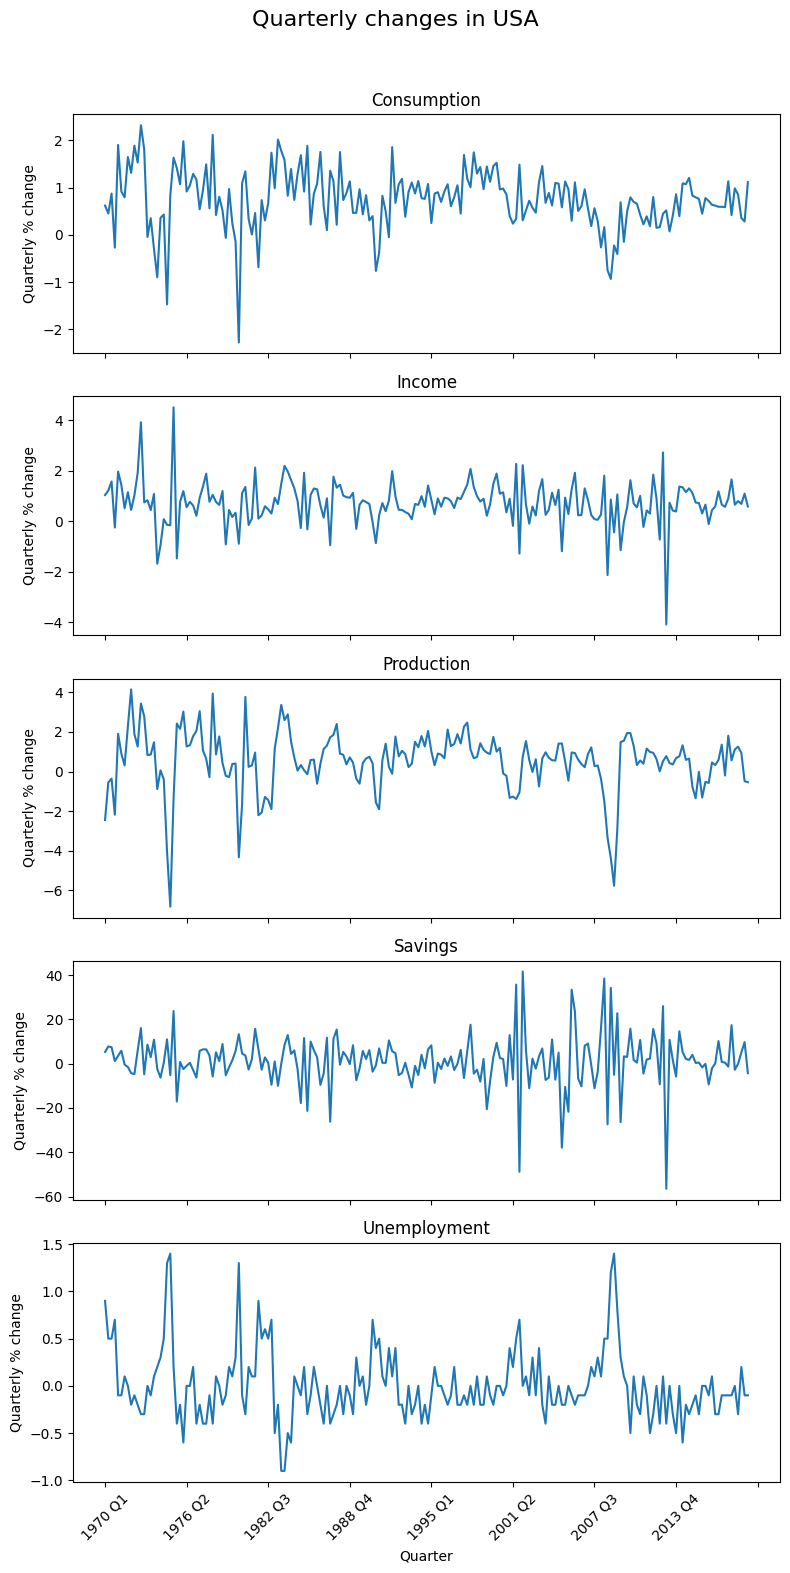

In [29]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# us_change = pd.read_csv("dataset/Ch.3/us_change.csv")
us_change = pd.read_csv("sample_data/us_change.csv")

variables = ["Consumption", "Income", "Production", "Savings", "Unemployment"]

fig, axes = plt.subplots(len(variables), 1, figsize=(8, 16), sharex=True)

for i, var in enumerate(variables):
    sns.lineplot(x='Quarter', y=var, data=us_change, ax=axes[i])
    axes[i].set_ylabel("Quarterly % change")
    axes[i].set_title(var)

    axes[i].tick_params(axis='x', rotation=45)

    axes[i].xaxis.set_major_locator(plt.MaxNLocator(10))

plt.suptitle("Quarterly changes in USA", fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.96])

plt.show()


In [33]:
import pandas as pd
import statsmodels.api as sm

y = us_change['Consumption']
X = us_change['Income']

X = sm.add_constant(X)

model = sm.tsa.SARIMAX(y, exog=X, order=(1, 0, 2))
fitted = model.fit(disp=False)

print(fitted.summary())

ar1 = fitted.params['ar.L1']
ma1 = fitted.params['ma.L1']
ma2 = fitted.params['ma.L2']
income_coef = fitted.params['Income']
intercept = fitted.params['const']

print(f"AR(1) coefficient: {ar1}")
print(f"MA(1) coefficient: {ma1}")
print(f"MA(2) coefficient: {ma2}")
print(f"Income coefficient: {income_coef}")
print(f"Intercept: {intercept}")

                               SARIMAX Results                                
Dep. Variable:            Consumption   No. Observations:                  198
Model:               SARIMAX(1, 0, 2)   Log Likelihood                -163.036
Date:                Tue, 20 Aug 2024   AIC                            338.072
Time:                        11:55:55   BIC                            357.802
Sample:                             0   HQIC                           346.058
                                - 198                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5949      0.085      7.028      0.000       0.429       0.761
Income         0.1976      0.034      5.855      0.000       0.131       0.264
ar.L1          0.7070      0.106      6.657      0.0

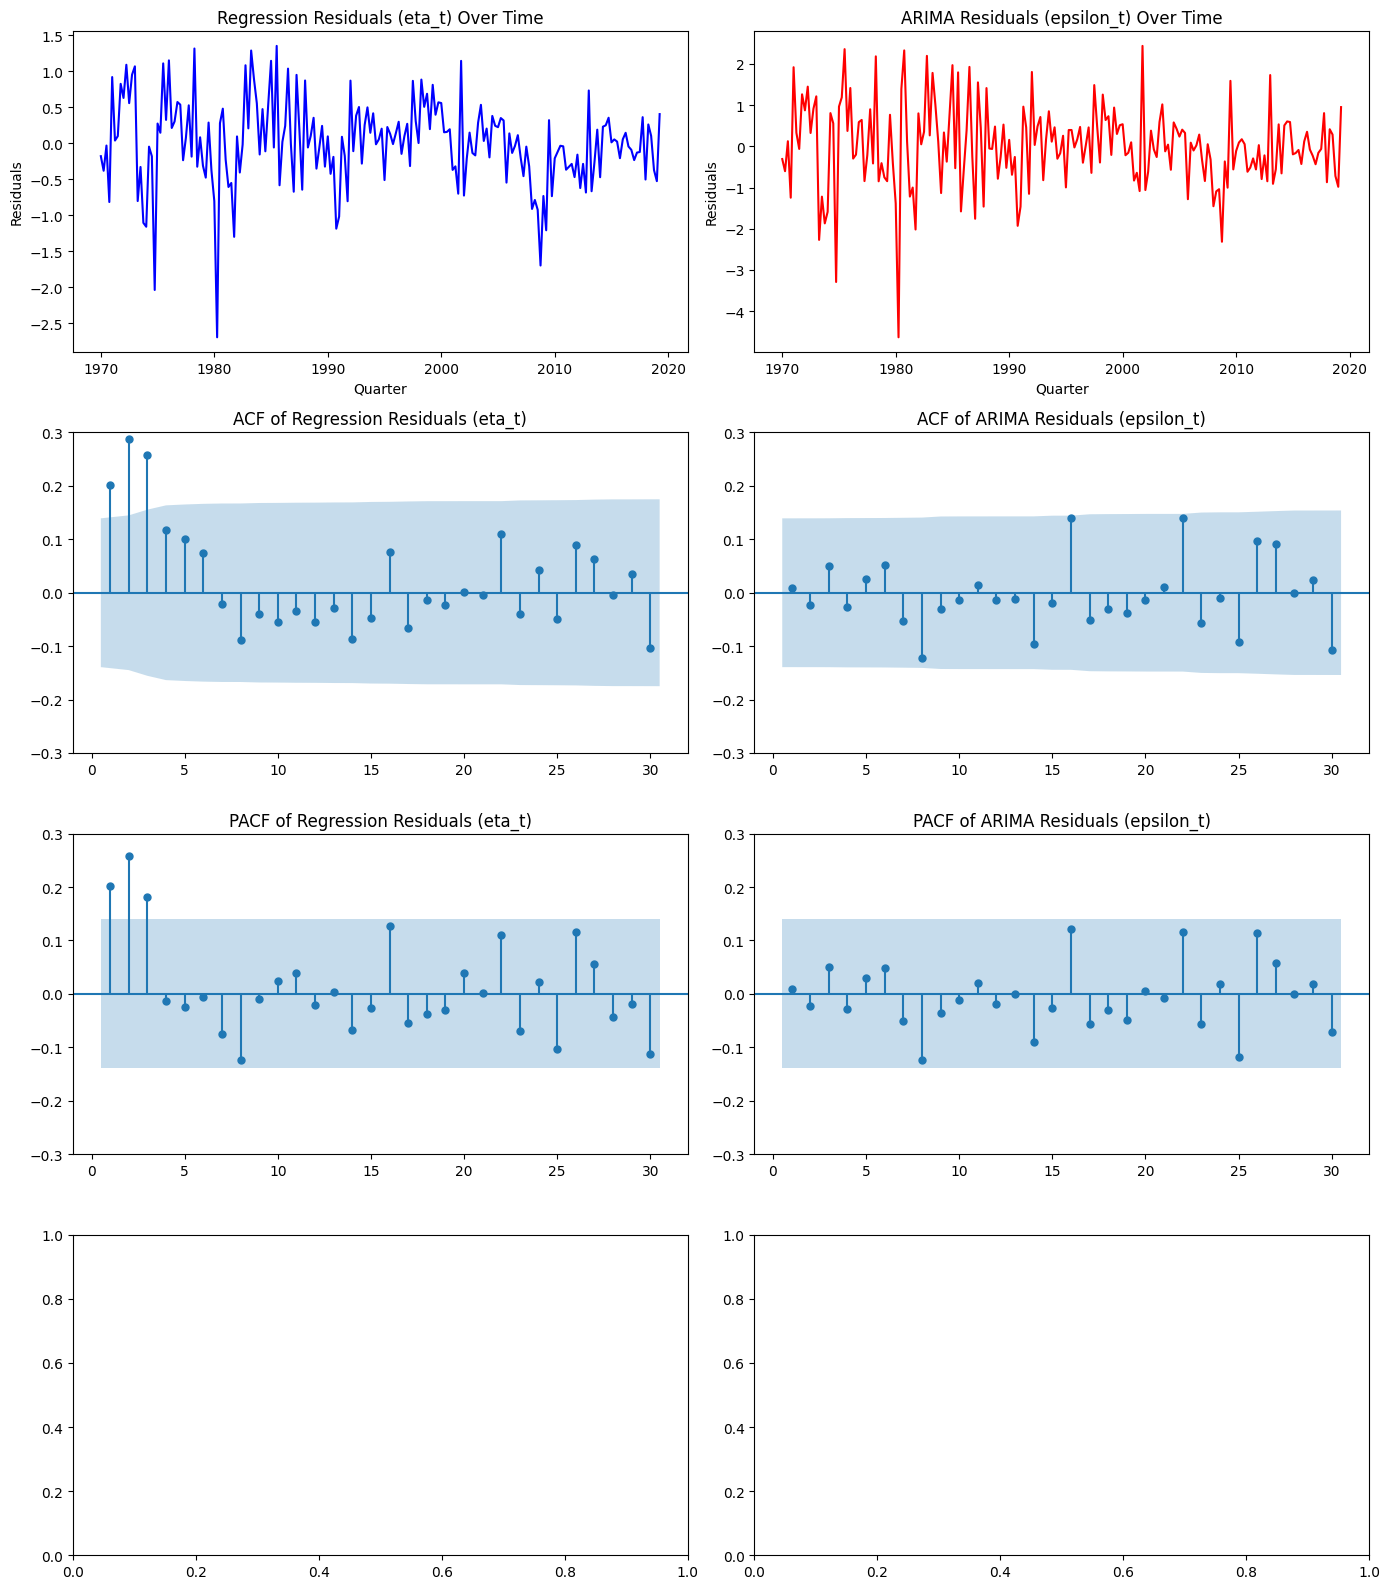

In [15]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

regression_residuals = y - X['Income']*income_coef - X['const']*intercept

arima_residuals = fitted.filter_results.standardized_forecasts_error[0]

fig, ax = plt.subplots(4, 2, figsize=(14, 16))

ax[0, 0].plot(us_change.index, regression_residuals, label='Regression Residuals', color='blue')
ax[0, 0].set_title('Regression Residuals (eta_t) Over Time')
ax[0, 0].set_xlabel('Quarter')
ax[0, 0].set_ylabel('Residuals')

sm.graphics.tsa.plot_acf(regression_residuals, lags=30, ax=ax[1, 0], zero=False)
ax[1, 0].set_title('ACF of Regression Residuals (eta_t)')
ax[1, 0].set_ylim(-0.3,0.3)

sm.graphics.tsa.plot_pacf(regression_residuals, lags=30, ax=ax[2, 0], zero=False)
ax[2, 0].set_title('PACF of Regression Residuals (eta_t)')
ax[2, 0].set_ylim(bottom=min(regression_residuals.min(), -1), top=max(regression_residuals.max(), 1))
ax[2, 0].set_ylim(-0.3,0.3)

ax[0, 1].plot(us_change.index, arima_residuals, label='ARIMA Residuals', color='red')
ax[0, 1].set_title('ARIMA Residuals (epsilon_t) Over Time')
ax[0, 1].set_xlabel('Quarter')
ax[0, 1].set_ylabel('Residuals')

sm.graphics.tsa.plot_acf(arima_residuals, lags=30, ax=ax[1, 1], zero=False)
ax[1, 1].set_title('ACF of ARIMA Residuals (epsilon_t)')
ax[1, 1].set_ylim(-0.3,0.3)

sm.graphics.tsa.plot_pacf(arima_residuals, lags=30, ax=ax[2, 1], zero=False)
ax[2, 1].set_title('PACF of ARIMA Residuals (epsilon_t)')
ax[2, 1].set_ylim(bottom=min(arima_residuals.min(), -1), top=max(arima_residuals.max(), 1))
ax[2, 1].set_ylim(-0.3,0.3)

plt.tight_layout()
plt.show()


In [31]:
def show_forecast(series, fitted, horizon, x, y, title):
    forecast = fitted.get_forecast(horizon).predicted_mean
    ci = fitted.get_forecast(horizon)
    lower_ci80 = ci.conf_int(alpha=0.2).iloc[:,0]
    upper_ci80 = ci.conf_int(alpha=0.2).iloc[:,1]
    lower_ci95 = ci.conf_int(alpha=0.05).iloc[:,0]
    upper_ci95 = ci.conf_int(alpha=0.05).iloc[:,1]

    plt.figure(figsize=(10, 6))
    plt.plot(series, label='Observation', color='black')
    plt.plot(forecast, label='forecast', color='b')
    plt.fill_between(forecast.index, lower_ci80, upper_ci80, label='80', color='b', alpha=.2)
    plt.fill_between(forecast.index, lower_ci95, upper_ci95, label='95', color='b', alpha=.1)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.show()

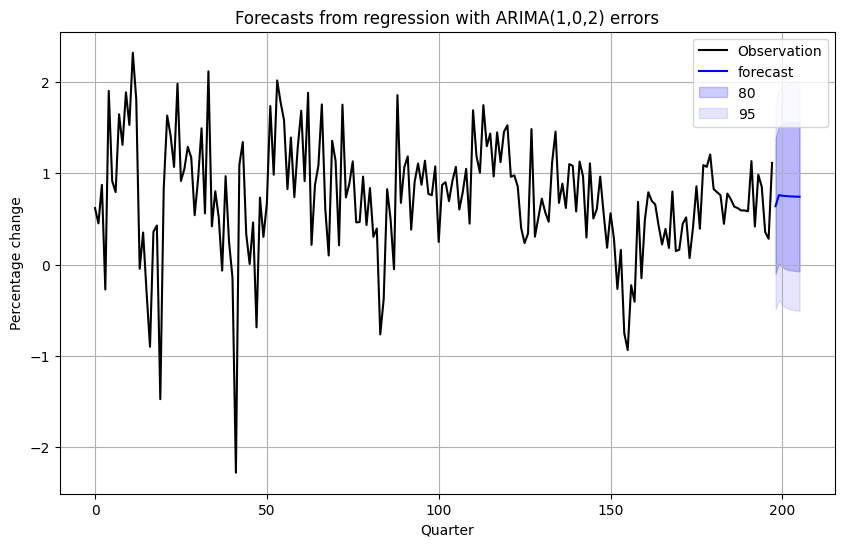

In [39]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Assuming 'us_change' is your existing dataframe
us_change = pd.read_csv("sample_data/us_change.csv")

# Step 1: Calculate the mean percentage change in Income over the last 40 years (40*4=160 quarters)
mean_income_change = us_change['Income'].tail(160).mean()

# Step 2: Convert the "Quarter" column to a pandas Period object
# Split the "Quarter" into Year and Quarter components
us_change['Year'] = us_change['Quarter'].str[:4].astype(int)
us_change['Qtr'] = us_change['Quarter'].str[-2:]

# Map "Q1", "Q2", etc., to month numbers and create a datetime column
quarter_to_month = {"Q1": "01", "Q2": "04", "Q3": "07", "Q4": "10"}
us_change['Month'] = us_change['Qtr'].map(quarter_to_month)
us_change['Date'] = pd.to_datetime(us_change[['Year', 'Month']].assign(DAY=1))

# Convert the datetime to a PeriodIndex
us_change['Quarter'] = us_change['Date'].dt.to_period('Q')

# Generate future dates based on the last available quarter
last_period = us_change['Quarter'].iloc[-1]
future_periods = [last_period + i for i in range(1, 9)]

# Create a new dataframe for the future eight quarters
us_change_future = pd.DataFrame({
    'Quarter': future_periods,
    'Income': np.repeat(mean_income_change, 8)
})



# Step 4: Forecast the next eight quarters using the fitted model
forecast = fitted.get_forecast(steps=8).predicted_mean
us_change_future['Consumption'] = forecast.values

# Combine the original data and the forecast data for plotting
us_change_full = pd.concat([us_change.set_index('Quarter'), us_change_future.set_index('Quarter')])

# Step 5: Use the show_forecast function to visualize the forecast
show_forecast(
    series=us_change['Consumption'],
    fitted=fitted,
    horizon=8,
    x='Quarter',
    y='Percentage change',
    title='Forecasts from regression with ARIMA(1,0,2) errors'
)


Electricity demand

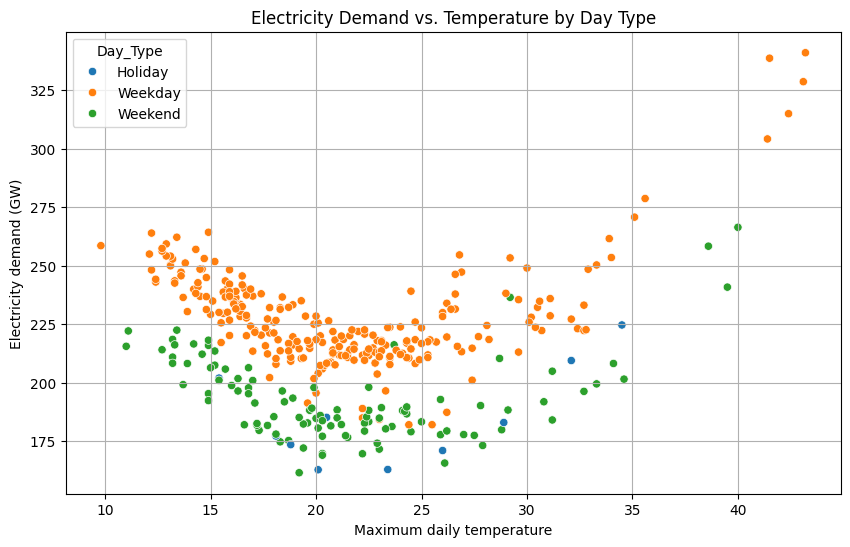

In [43]:
vic_elec = pd.read_csv("sample_data/vic_elec.csv")
# Step 1: Data Manipulation

# Convert 'Time' to datetime, handling inconsistencies
vic_elec['Time'] = pd.to_datetime(vic_elec['Time'], format='%Y-%m-%d %H:%M:%S', errors='coerce')

# Extract just the date component
vic_elec['Date'] = vic_elec['Time'].dt.date

# Filter for the year 2014
vic_elec_2014 = vic_elec[pd.to_datetime(vic_elec['Date']).dt.year == 2014]

# Aggregate data by date
vic_elec_daily = vic_elec_2014.groupby('Date').agg({
    'Demand': lambda x: x.sum() / 1e3,  # Sum the demand and convert to GW
    'Temperature': 'max',  # Get the max temperature
    'Holiday': 'any'  # Check if any of the days are holidays
}).reset_index()

# Determine the type of day
vic_elec_daily['Day_Type'] = np.where(
    vic_elec_daily['Holiday'], 'Holiday',
    np.where(pd.to_datetime(vic_elec_daily['Date']).dt.weekday.isin([0, 1, 2, 3, 4]), 'Weekday', 'Weekend')
)

# Step 2: Plotting

# Initialize the plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=vic_elec_daily, x='Temperature', y='Demand', hue='Day_Type')

# Add labels and title
plt.xlabel('Maximum daily temperature')
plt.ylabel('Electricity demand (GW)')
plt.title('Electricity Demand vs. Temperature by Day Type')

# Display the plot
plt.grid(True)
plt.show()


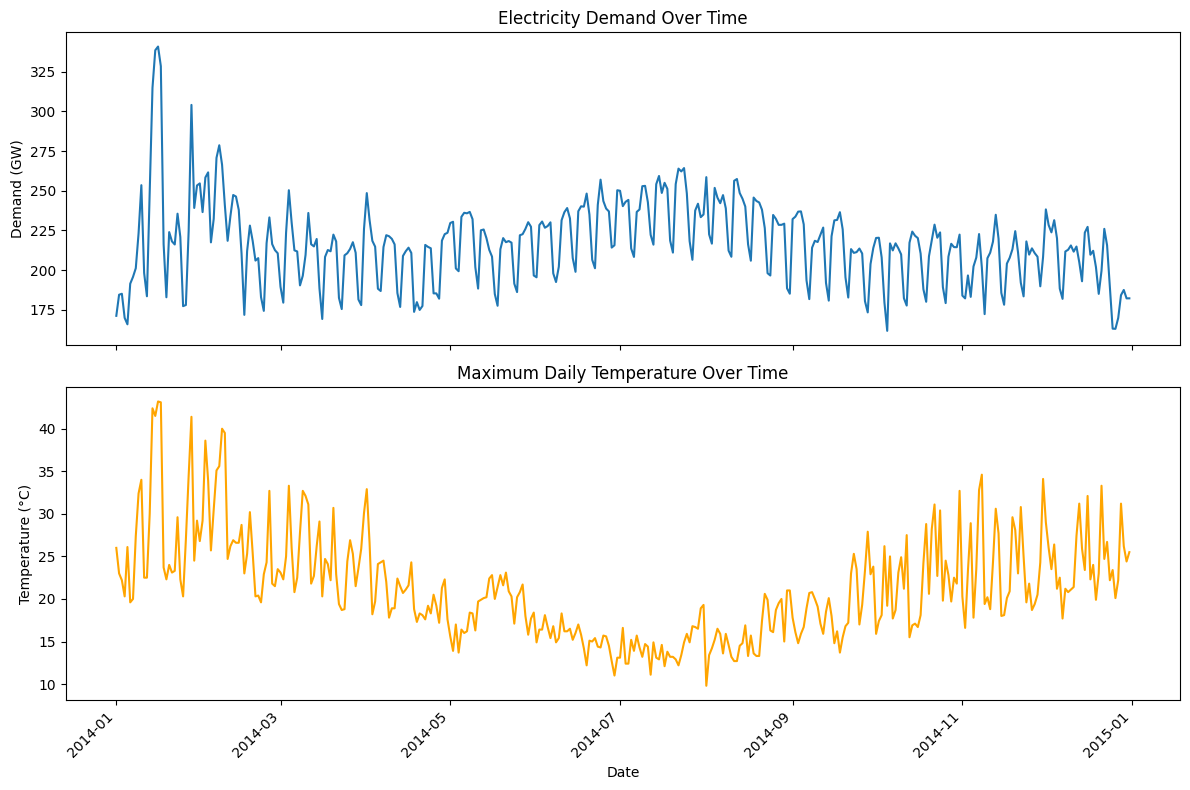

In [46]:
# Assuming vic_elec_daily is your DataFrame after the previous manipulation

# Step 1: Pivot the data to a long format
vic_elec_long = pd.melt(vic_elec_daily, id_vars=['Date'], value_vars=['Demand', 'Temperature'],
                        var_name='name', value_name='value')

# Step 2: Plotting without FacetGrid

# Create a figure and axes
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Plot Demand
ax1.plot(vic_elec_long[vic_elec_long['name'] == 'Demand']['Date'],
         vic_elec_long[vic_elec_long['name'] == 'Demand']['value'], label='Demand')
ax1.set_ylabel('Demand (GW)')
ax1.set_title('Electricity Demand Over Time')

# Plot Temperature
ax2.plot(vic_elec_long[vic_elec_long['name'] == 'Temperature']['Date'],
         vic_elec_long[vic_elec_long['name'] == 'Temperature']['value'], label='Temperature', color='orange')
ax2.set_ylabel('Temperature (°C)')
ax2.set_title('Maximum Daily Temperature Over Time')

# Common x-axis label
ax2.set_xlabel('Date')

# Rotate x-axis labels for better readability
plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

<ipython-input-49-94eef49c79cd>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Temperature^2'] = vic_elec_daily['Temperature'] ** 2
<ipython-input-49-94eef49c79cd>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Weekday'] = vic_elec_daily['Weekday']
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


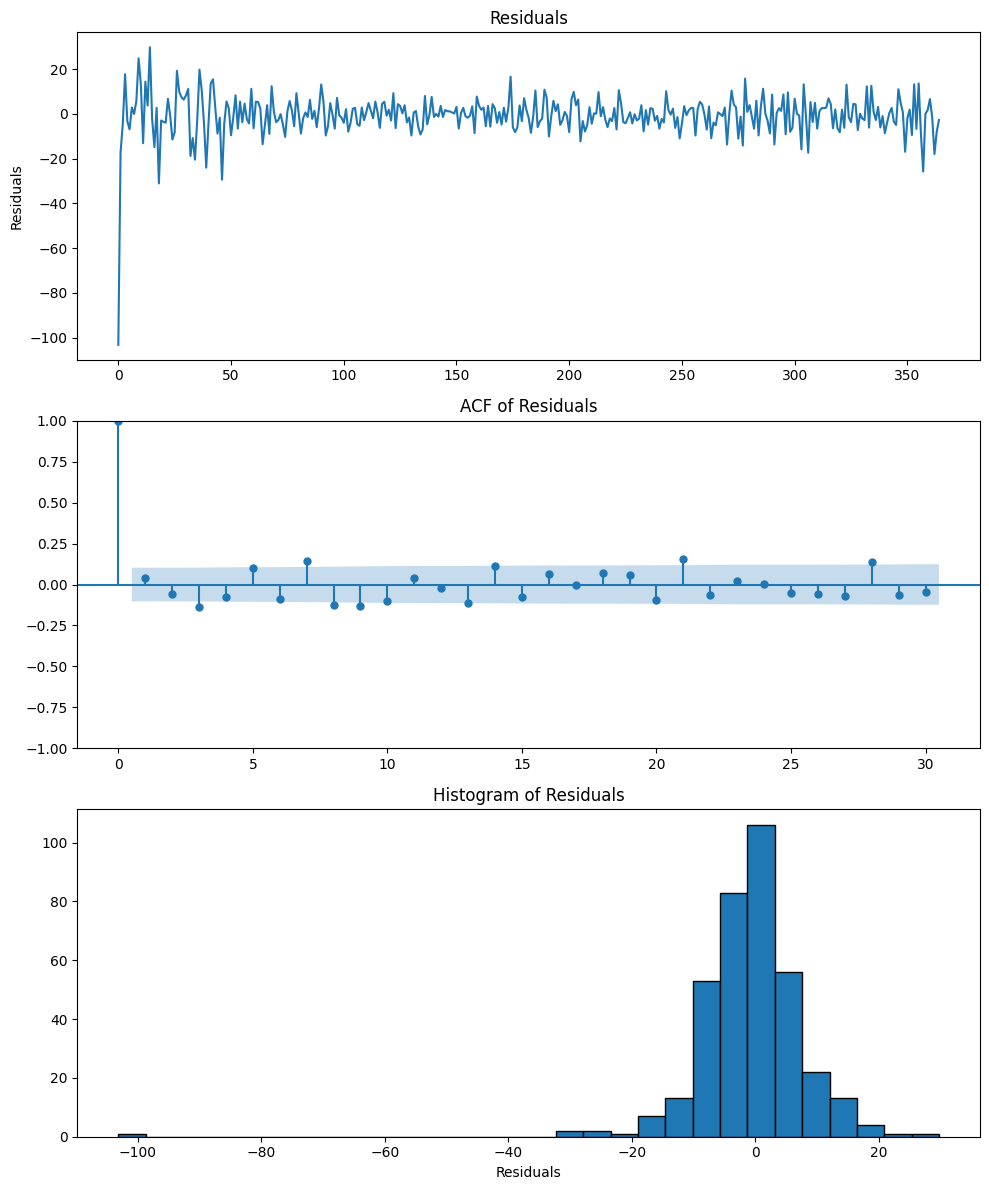

In [49]:
vic_elec = pd.read_csv("sample_data/vic_elec.csv")

vic_elec_daily['Weekday'] = (vic_elec_daily['Day_Type'] == 'Weekday').astype(int)

# Prepare the exogenous variables (Temperature, Temperature^2, Weekday)
X = vic_elec_daily[['Temperature']]
X['Temperature^2'] = vic_elec_daily['Temperature'] ** 2
X['Weekday'] = vic_elec_daily['Weekday']

# Step 2: Fit the ARIMA model
# We will use an ARIMA model with the exogenous variables
model = sm.tsa.ARIMA(vic_elec_daily['Demand'], exog=X, order=(2, 0, 0))
fit = model.fit()

# Step 3: Plot the residuals
residuals = fit.resid

# Plotting the residuals
fig, ax = plt.subplots(3, 1, figsize=(10, 12))

# Residual plot
ax[0].plot(residuals)
ax[0].set_title('Residuals')
ax[0].set_ylabel('Residuals')

# ACF plot of residuals
sm.graphics.tsa.plot_acf(residuals, ax=ax[1], lags=30)
ax[1].set_title('ACF of Residuals')

# Histogram of residuals
ax[2].hist(residuals, bins=30, edgecolor='black')
ax[2].set_title('Histogram of Residuals')
ax[2].set_xlabel('Residuals')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()